In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print(sns.__version__)
import os 
from datetime import datetime

0.11.1


In [2]:
basedirectory = os.getcwd()
os.chdir(r"C:\Users\ivann\OneDrive\Documents\~General Assembly Documents")


In [3]:
raw_data = pd.read_csv("DSI_kickstarterscrape_dataset.csv", encoding ="latin-1")

In [4]:
raw_data.head()
#two things you shoul always do, dataset.info() and dataset.describe()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,"Fri, 19 Aug 2011 19:28:17 -0000",7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,"Mon, 02 Aug 2010 03:59:00 -0000",5,"$1,$5,$10,$25,$50",6,0,47.18
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,"Fri, 08 Jun 2012 00:00:31 -0000",10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,"Sun, 08 Apr 2012 02:14:00 -0000",13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,"Wed, 01 Jun 2011 15:25:39 -0000",6,"$10,$25,$50,$100,$150,$250",2,0,30.00


In [5]:
display(raw_data.info())
display(raw_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45957 entries, 0 to 45956
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   project id         45957 non-null  int64  
 1   name               45957 non-null  object 
 2   url                45957 non-null  object 
 3   category           45957 non-null  object 
 4   subcategory        45957 non-null  object 
 5   location           44635 non-null  object 
 6   status             45957 non-null  object 
 7   goal               45957 non-null  float64
 8   pledged            45945 non-null  float64
 9   funded percentage  45957 non-null  float64
 10  backers            45957 non-null  int64  
 11  funded date        45957 non-null  object 
 12  levels             45957 non-null  int64  
 13  reward levels      45898 non-null  object 
 14  updates            45957 non-null  int64  
 15  comments           45957 non-null  int64  
 16  duration           459

None

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.080800e+09,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,6.218057e+08,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,5.438962e+08,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,1.078345e+09,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,1.621596e+09,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


In [6]:
#Let's update the data types on our raw data
data_updated_dtype = raw_data

In [7]:
#changing the project id from an integer to a string
data_updated_dtype['project id'] = data_updated_dtype['project id'].astype('string')


#let's put the day of the week into it's own column
data_updated_dtype[['Day of Week','funded date']] = data_updated_dtype['funded date'].str.split(',',n=1,expand=True)
#let's remove the annoying zeros at the end of the each entry
data_updated_dtype['funded date']= data_updated_dtype['funded date'].str.rstrip('-0000')
data_updated_dtype['Funded Date'] = pd.to_datetime(data_updated_dtype['funded date']).dt.date
data_updated_dtype['Funded Time'] = pd.to_datetime(data_updated_dtype['funded date']).dt.time
data_updated_dtype.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration,Day of Week,Funded Date,Funded Time
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,19 Aug 2011 19:28:17,7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00,Fri,2011-08-19,19:28:17
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,02 Aug 2010 03:59:00,5,"$1,$5,$10,$25,$50",6,0,47.18,Mon,2010-08-02,03:59:00
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,08 Jun 2012 00:00:31,10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00,Fri,2012-06-08,00:00:31
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,08 Apr 2012 02:14:00,13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22,Sun,2012-04-08,02:14:00
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,01 Jun 2011 15:25:39,6,"$10,$25,$50,$100,$150,$250",2,0,30.00,Wed,2011-06-01,15:25:39


In [8]:
data_updated_dtype.describe()

,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


In [9]:
#Now let's drop the original date time column
data_updated_dtype.drop(columns = ['funded date'], inplace = True)
data_updated_dtype.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,reward levels,updates,comments,duration,Day of Week,Funded Date,Funded Time
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00,Fri,2011-08-19,19:28:17
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,"$1,$5,$10,$25,$50",6,0,47.18,Mon,2010-08-02,03:59:00
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00,Fri,2012-06-08,00:00:31
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22,Sun,2012-04-08,02:14:00
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,"$10,$25,$50,$100,$150,$250",2,0,30.00,Wed,2011-06-01,15:25:39


In [10]:
data_updated_dtype.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,reward levels,updates,comments,duration,Day of Week,Funded Date,Funded Time
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00,Fri,2011-08-19,19:28:17
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,"$1,$5,$10,$25,$50",6,0,47.18,Mon,2010-08-02,03:59:00
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00,Fri,2012-06-08,00:00:31
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22,Sun,2012-04-08,02:14:00
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,"$10,$25,$50,$100,$150,$250",2,0,30.00,Wed,2011-06-01,15:25:39


In [11]:
#Let's check to see what type of data we have
data_updated_dtype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45957 entries, 0 to 45956
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   project id         45957 non-null  string 
 1   name               45957 non-null  object 
 2   url                45957 non-null  object 
 3   category           45957 non-null  object 
 4   subcategory        45957 non-null  object 
 5   location           44635 non-null  object 
 6   status             45957 non-null  object 
 7   goal               45957 non-null  float64
 8   pledged            45945 non-null  float64
 9   funded percentage  45957 non-null  float64
 10  backers            45957 non-null  int64  
 11  levels             45957 non-null  int64  
 12  reward levels      45898 non-null  object 
 13  updates            45957 non-null  int64  
 14  comments           45957 non-null  int64  
 15  duration           45957 non-null  float64
 16  Day of Week        459

In [12]:
data_updated_dtype.isna().any() #let's check for missing values in our updated dtype data set
#Expected output: 
# project id           False
# name                 False
# url                  False
# category             False
# subcategory          False
# location              True
# status               False
# goal                 False
# pledged               True
# funded percentage    False
# backers              False
# levels               False
# reward levels         True
# updates              False
# comments             False
# duration             False
# Day of Week          False
# Funded Date          False
# Funded Time          False
# dtype: bool

project id           False
name                 False
url                  False
category             False
subcategory          False
location              True
status               False
goal                 False
pledged               True
funded percentage    False
backers              False
levels               False
reward levels         True
updates              False
comments             False
duration             False
Day of Week          False
Funded Date          False
Funded Time          False
dtype: bool

In [13]:
#rename two word columns to be correct
data_updated_dtype["reward_levels"]=data_updated_dtype['reward levels']


In [14]:
#remove old reward levels column
data_updated_dtype.drop(columns=['reward levels'],inplace=True, axis=1)
data_updated_dtype.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,1,0,28.00,Fri,2012-06-08,00:00:31,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001"
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"


In [15]:
#calling the number of null values in a specific column
pledged_null = data_updated_dtype.isnull().pledged.sum()
location_null = data_updated_dtype.isnull().location.sum()
reward_null = data_updated_dtype.isnull().reward_levels.sum()
print("null location count", location_null)
print("pledged null", pledged_null)  
print ("reward levels null", reward_null)

null location count 1322
pledged null 12
reward levels null 59


In [16]:
#Let's drop any rows that are missing locations, since we have no way to determine what the Location should be from the data we have.
data_updated_dtype.dropna(subset=['location'],inplace=True)

#let's double check that we removed all the null values
location_null = data_updated_dtype.isnull().location.sum()
print("null location count", location_null)

null location count 0


In [17]:
#let's drop the rows missing reward levels since we have no way to calculate this as well.
data_updated_dtype.dropna(subset=['reward_levels'],inplace=True)

#let's double check that we removed all the null values
reward_null = data_updated_dtype.isnull().reward_levels.sum()
print ("reward levels null", reward_null)

reward levels null 0


In [18]:
#We will now attempt to update the null pldeged values using Goal amount and funded percentage
#call all rows that do not contain a pledged amount
#Let's calculate a new column called "Calculted_Pledged" and compare that with the reported pldege amounts to see if they are 
#the same.
data_updated_dtype['Calculated_Pledged']=round(data_updated_dtype['goal']*(data_updated_dtype['funded percentage']),0)
data_updated_dtype['pledgedMatch?'] = np.where(data_updated_dtype['pledged'] == data_updated_dtype['Calculated_Pledged'], 'True', 'False')  
#create new column in df1 to check if pledged amounts  match

data_updated_dtype.sample(100)


,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,...,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels,Calculated_Pledged,pledgedMatch?
12212,578778388,Michael: A short film by Harry Bainbridge,http://www.kickstarter.com/projects/1447871700...,Film &amp; Video,Short Film,"Lakeville, CT",successful,5000.0,5040.0,1.008000,...,7,1,1,40.76,Mon,2011-05-30,22:07:00,"$5,$10,$25,$50,$100,$500,$1,000",5040.0,True
7456,353299186,&quot;Falling&quot; - A USC Student Film,http://www.kickstarter.com/projects/11616752/f...,Film &amp; Video,Short Film,"Los Angeles, CA",successful,500.0,685.0,1.370000,...,2,3,0,14.00,Thu,2011-10-27,06:21:52,"$1,$25",685.0,True
3925,185627289,THE PURITANS,http://www.kickstarter.com/projects/1949248031...,Film &amp; Video,Short Film,"Brooklyn, NY",successful,5000.0,5200.0,1.040000,...,4,1,3,29.96,Wed,2012-03-28,13:30:04,"$30,$50,$100,$1,000",5200.0,True
12045,571157200,Palms- Because Every Child Deserves a Forever ...,http://www.kickstarter.com/projects/1032033017...,Film &amp; Video,Short Film,"Los Angeles, CA",successful,2000.0,2095.0,1.047500,...,9,4,0,29.96,Sat,2012-04-07,02:12:31,"$1,$5,$10,$25,$50,$100,$250,$500,$1,000",2095.0,True
13215,628288377,SEVEN GENERATIONS: a farm family rewrites thei...,http://www.kickstarter.com/projects/hestersche...,Film &amp; Video,Short Film,"Half Moon Bay, CA",failed,35000.0,1760.0,0.050286,...,6,2,0,60.00,Tue,2011-09-06,17:56:02,"$25,$100,$500,$1,000,$5,000,$10,000",1760.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23213,1090529933,Counter Culture is relocating to a Building!,http://www.kickstarter.com/projects/1280533163...,Food,Food,"Austin, TX",successful,11000.0,13200.0,1.200011,...,4,9,8,30.00,Wed,2012-02-01,06:10:54,"$10,$35,$60,$150",13200.0,True
14162,672632992,Afterlife,http://www.kickstarter.com/projects/2070138897...,Film &amp; Video,Short Film,"Boston, MA",successful,1000.0,1130.0,1.130000,...,4,0,1,20.81,Thu,2012-03-15,17:40:00,"$10,$20,$50,$100",1130.0,True
31992,1506174979,Dave Birk's Debut Album --- Speed Queen Myster...,http://www.kickstarter.com/projects/davebirkcr...,Music,Pop,"Minneapolis, MN",successful,5432.0,5815.0,1.070508,...,11,9,6,32.08,Mon,2011-11-14,05:59:00,"$1,$10,$20,$34,$59,$86,$123,$250,$299,$400,$1,250",5815.0,True
13467,640161736,The One Minute Gardener,http://www.kickstarter.com/projects/baff/the-o...,Film &amp; Video,Film &amp; Video,"San Francisco, CA",successful,2500.0,2500.0,1.000000,...,11,17,0,45.04,Wed,2011-11-30,21:46:58,"$1,$5,$10,$25,$35,$50,$100,$150,$400,$500,$1,500",2500.0,True


In [19]:
#Let's add in the pldged amount where appropiate in our dataset
nullpledged_df = data_updated_dtype[data_updated_dtype.isnull().pledged]
nullpledged_df.head(20) #there should only be 12 rows in the pledged null data frame
# data_updated_dtype['pledged']=round(nullpledged_df['goal']*(nullpledged_df['funded percentage']),0)
# pledged_null = data_updated_dtype.isnull().pledged.sum()
# print("pledged null", pledged_null)  



,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,...,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels,Calculated_Pledged,pledgedMatch?
1187,55442017,Xenonauts,http://www.kickstarter.com/projects/69341191/x...,Games,Video Games,"London, United Kingdom",live,50000.0,NaN,2.219487,...,17,8,562,33.00,Sun,2012-06-10,23:19:04,"$20,$30,$50,$50,$50,$60,$75,$85,$100,$100,$125...",110974.0,False
4502,213683990,Twokinds Book Printing Drive,http://www.kickstarter.com/projects/twokinds/t...,Comics,Comics,"Cincinnati, OH",live,25000.0,NaN,6.303783,...,34,6,1133,31.24,Sat,2012-06-09,20:00:00,"$10,$12,$15,$20,$20,$20,$20,$25,$25,$35,$35,$4...",157595.0,False
13381,636029584,HICKIES - TURN YOUR KICKS INTO SLIP-ONS,http://www.kickstarter.com/projects/hickies/hi...,Design,Product Design,"Brooklyn, NY",live,25000.0,NaN,4.907843,...,9,6,119,45.00,Thu,2012-06-14,15:44:14,"$16,$30,$45,$59,$75,$90,$115,$300,$500",122696.0,False
13802,656206605,Genie - Motion control time lapse device,http://www.kickstarter.com/projects/syrp/genie...,Design,Product Design,"Queenstown, New Zealand",live,150000.0,NaN,2.999618,...,13,10,89,60.00,Tue,2012-06-26,06:29:41,"$1,$15,$30,$50,$100,$590,$690,$750,$790,$3,000...",449943.0,False
25239,1184761342,B9Creator - A High Resolution 3D Printer,http://www.kickstarter.com/projects/b9creation...,Technology,Open Hardware,"Deadwood, SD",live,50000.0,NaN,4.761380,...,11,12,100,33.07,Tue,2012-06-12,07:00:00,"$5,$25,$59,$99,$132,$183,$216,$2,375,$2,675,$3...",238069.0,False
29412,1382865280,Phil Tippett's &quot;MAD GOD&quot;,http://www.kickstarter.com/projects/madgod/phi...,Film &amp; Video,Animation,"Berkeley, CA",live,40000.0,NaN,2.532484,...,10,3,59,30.00,Sat,2012-06-16,22:36:31,"$10,$25,$55,$75,$100,$115,$300,$1,800,$3,600,$...",101299.0,False
31164,1467412732,gTar: The First Guitar That Anybody Can Play,http://www.kickstarter.com/projects/incident/g...,Technology,Technology,"Santa Clara, CA",live,100000.0,NaN,2.846420,...,11,4,44,35.00,Mon,2012-06-25,17:26:04,"$1,$25,$350,$399,$450,$499,$599,$699,$799,$999...",284642.0,False
34274,1612550316,Space Command,http://www.kickstarter.com/projects/58936338/s...,Film &amp; Video,Film &amp; Video,"Studio City, CA",live,75000.0,NaN,1.796187,...,22,24,279,60.00,Sun,2012-07-15,03:59:00,"$5,$8,$12,$17,$27,$37,$50,$67,$107,$257,$357,$...",134714.0,False
35032,1648656751,BronyCon: The Documentary,http://www.kickstarter.com/projects/257527888/...,Film &amp; Video,Documentary,"Los Angeles, CA",live,60000.0,NaN,3.148185,...,15,5,525,26.97,Sun,2012-06-10,18:59:00,"$10,$10,$30,$50,$75,$100,$150,$250,$500,$500,$...",188891.0,False
40759,1911111579,Two Guys SpaceVenture - by the creators of Spa...,http://www.kickstarter.com/projects/spaceventu...,Games,Video Games,"Eugene, OR",live,500000.0,NaN,0.583738,...,33,30,6895,35.00,Tue,2012-06-12,17:27:38,"$15,$30,$31,$45,$50,$60,$75,$100,$100,$101,$11...",291869.0,False


In [20]:
#Let's attempt to fill in the values for this temporary data frame
#the following code snippet was me testing how to use the np.where function, which essentialy acts like an if-then function.
#The function worked the way that I hoped it would
# nullpledged_df['pledged'] = np.where(nullpledged_df['pledged'].isnull(),round(nullpledged_df['goal']*(nullpledged_df['funded percentage']),0),nullpledged_df['pledged'])
# nullpledged_df.head(12)


In [21]:
#Use the numpy "where" function to replace NAN values in the data set with by calculating pledged amount from fundraising goal * pledged percentage.
data_updated_dtype['pledged'] = np.where(data_updated_dtype['pledged'].isnull(),round(data_updated_dtype['goal']*(data_updated_dtype['funded percentage']),0),data_updated_dtype['pledged'])
pledged_null = data_updated_dtype.isnull().pledged.sum()
#the expected output is 0. 
print("pledged null", pledged_null) 

pledged null 0


In [22]:
#create a new dataset to be used for further data cleaning
#We need to drop the extra columns we created, i.e. pledgedmatch? and calculated pledge
data_updated_dtype.drop(columns= ['Calculated_Pledged','pledgedMatch?'], inplace=True)
no_nulls_data= data_updated_dtype
no_nulls_data.head()



,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,1,0,28.00,Fri,2012-06-08,00:00:31,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001"
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"


In [23]:
#Next Step: Let's make sure all categories are unique and consistent
print(no_nulls_data.category.unique())
print(no_nulls_data.groupby(['category'])['category'].count())
#From our output, we see that Film & Video is written two ways, Film & Video + Film &amp; Video
#The total expected amount of listings that fall in the Film & video category is 13,082
#Expected output
# category
    # Art                  3872
    # Comics               1034
    # Dance                 744
    # Design               1738
    # Fashion              1117
    # Film & Video          482
    # Film &amp; Video    12600
    # Food                 1411
    # Games                1689
    # Music               10671
    # Photography          1424
    # Publishing           4585
    # Technology            774
    # Theater              2451

['Film & Video' 'Games' 'Fashion' 'Music' 'Art' 'Dance' 'Publishing'
 'Theater' 'Comics' 'Technology' 'Design' 'Photography' 'Food'
 'Film &amp; Video']
category
Art                  3872
Comics               1034
Dance                 744
Design               1738
Fashion              1117
Film & Video          482
Film &amp; Video    12600
Food                 1411
Games                1689
Music               10671
Photography          1424
Publishing           4585
Technology            774
Theater              2451
Name: category, dtype: int64


In [24]:
#Relace all instances of Film &amp; Video with Film & Video
no_nulls_data['category'] = np.where(no_nulls_data['category'] =='Film &amp; Video','Film & Video',no_nulls_data['category'])
print(no_nulls_data.groupby(['category'])['category'])


In [25]:
#let's identify the unique values of our subcategories
# print(no_nulls_data.subcategory.unique())
print(no_nulls_data.groupby(['subcategory'])['subcategory'].count())
# print(no_nulls_data.loc[no_nulls_data['subcategory'] == 'Board & Card Games'].count())


subcategory
Animation                  407
Art                       1037
Art Book                   333
Board & Card Games         110
Board &amp; Card Games     432
Children's Book            640
Classical Music            470
Comics                    1034
Conceptual Art             168
Country & Folk             249
Country &amp; Folk         777
Crafts                     247
Dance                      744
Design                     281
Digital Art                139
Documentary               3798
Electronic Music           298
Fashion                   1117
Fiction                   1057
Film &amp; Video          2432
Food                      1411
Games                      267
Graphic Design             171
Hip-Hop                    467
Illustration               195
Indie Rock                1880
Jazz                       431
Journalism                 381
Mixed Media                443
Music                     3187
Narrative Film            1510
Nonfiction                1

In [26]:
#Let's redefine Board &amp; Card Games,  Country &amp; Folk  ,  Film &amp; Video
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Film &amp; Video','Film & Video',no_nulls_data['subcategory'])
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Country &amp; Folk','Country & Folk',no_nulls_data['subcategory'])
no_nulls_data['subcategory'] = np.where(no_nulls_data['subcategory'] =='Board &amp; Card Games','Board & Card Games',no_nulls_data['subcategory'])

# for item  in no_nulls_data['subcategory']:
#     if (item == 'Film &amp; Video'):
#         no_nulls_data['subcategory'][item]= ('Film & Video')
#     else:
#         item = item
    
# no_nulls_data.shape
#In order to iterate over an index I need to reindex my code.
no_nulls_data.reset_index(drop=True, inplace= True)
no_nulls_data.head(20)
# print(no_nulls_data['subcategory'][0]);
# print(no_nulls_data['subcategory'][11]);
# i = 0;
# for i in range(len(no_nulls_data['subcategory'])):
# #     print(no_nulls_data['category'][i])
#     if no_nulls_data['subcategory'][i] == 'Film &amp; Video':
#         no_nulls_data['subcategory'][i] ="Film & Video"
#     elif no_nulls_data['subcategory'][i] == 'Board &amp; Card Games':
#         no_nulls_data['subcategory'][i] = "Board & Card Games"
#     elif no_nulls_data['subcategory'][i] == 'Country &amp; Folk':
#         no_nulls_data['subcategory'][i] ="Country & Folk"
# no_nulls_data.column = df.column.apply(<urstuff>)
    
        
        
#     if no_nulls_data['subcategory'][i] == 'Film &amp; Video':
#         no_nulls_data['subcategory'][i] = "Film & video"
#     else:
#         no_nulls_data['subcategory'][i] = no_nulls_data['subcategory'][i]
# no_nulls_data.head(20)
#Print statement to make sure everything was renamed properly
#print(no_nulls_data.subcategory.unique())
no_nulls_data.head()




,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,10,1,0,28.00,Fri,2012-06-08,00:00:31,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001"
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"


In [27]:
#Let's remove extra columns if possible
# print(no_nulls_data['pledgedMatch?'].is())
# print(no_nulls_data['goal'].count())

In [28]:
#Rename no_null_data to the final dataset since everything is finally cleaned
#Convert the the decimal repesentation of funded percentage to actually correspond with the percentage
no_nulls_data['funded percentage']= no_nulls_data['funded percentage'].apply(lambda x: x*100)
final_data=no_nulls_data

In [29]:
#Let's describe our data set 
round(final_data.describe(),2)
#             goal   	pledged  	funded percentage	backers 	levels  	updates 	comments	duration
# count	4.459200e+04	4.459200e+04	44592.000	44592.000  	44592.000	44592.000	44592.000	44592.000
# mean	1.210894e+04	5.104144e+03	165.889 	71.038  	8.047	4.069	8.526	39.628
# std	1.916062e+05	5.769624e+04	7634.553	698.999  	4.247	6.404	176.651	17.087
# min	5.000000e-01	0.000000e+00	0.000   	0.000   	1.000	0.000	0.000	1.000
# 25%	1.800000e+03	2.000000e+02	4.500   	5.000   	5.000	0.000	0.000	30.000
# 50%	4.000000e+03	1.326000e+03	100.000 	23.000  	8.000	2.000	0.000	31.605
# 75%	1.000000e+04	4.205000e+03	111.667 	60.000  	10.000	6.000	3.000	47.020
# max	2.147484e+07	1.026684e+07	1506600.000	87142.000	80.000	149.000	19311.000	91.960

,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,44592.00,44592.00,44592.00,44592.00,44592.00,44592.00,44592.00,44592.00
mean,12108.94,5104.14,165.89,71.04,8.05,4.07,8.53,39.63
std,191606.24,57696.23,7634.55,699.00,4.25,6.40,176.65,17.09
min,0.50,0.00,0.00,0.00,1.00,0.00,0.00,1.00
25%,1800.00,200.00,4.50,5.00,5.00,0.00,0.00,30.00
50%,4000.00,1326.00,100.00,23.00,8.00,2.00,0.00,31.60
75%,10000.00,4205.00,111.67,60.00,10.00,6.00,3.00,47.02
max,21474836.47,10266845.00,1506600.00,87142.00,80.00,149.00,19311.00,91.96


Percentage of campaigns with no updates 0.35


<AxesSubplot:xlabel='updates', ylabel='Count'>

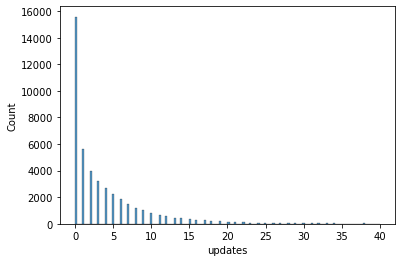

In [30]:
#Let's start plotting our data to understand what is going on!

#Let's try some basic analysis, how do # of updates affect funding percentage. Let's color code it by category for fun
print("Percentage of campaigns with no updates" + ' '+ 
      str(round(final_data.loc[final_data['updates'] ==0, ['updates']].count()[0] 
        #this counts all the situations where updates are = 0, #the [0] at the end is because the original output is a 1x1 array and I only need a single value
      /final_data.updates.count(),2)))
sns.histplot(final_data["updates"], binrange= [0, 40])
#Turns out that a vast majority of the 

In [31]:
#Lets look at a histogram for each coloumn shall we
print(final_data.groupby(['goal']).goal.count())
# sns.histplot(final_data["goal"])


goal
0.50            1
1.00           30
1.85            1
2.00            1
3.00            2
               ..
5250000.00      1
15000000.00     1
20000000.00     1
21474836.00     1
21474836.47     1
Name: goal, Length: 1794, dtype: int64


<AxesSubplot:xlabel='pledged', ylabel='Count'>

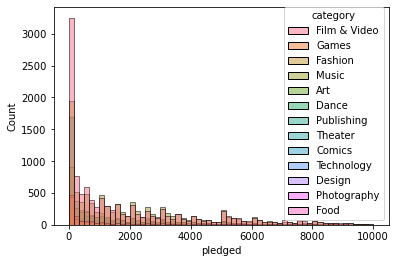

In [32]:
figsize = (15,10)
sns.histplot(data=final_data,x = 'pledged', binrange= [0, 10000], hue= 'category')


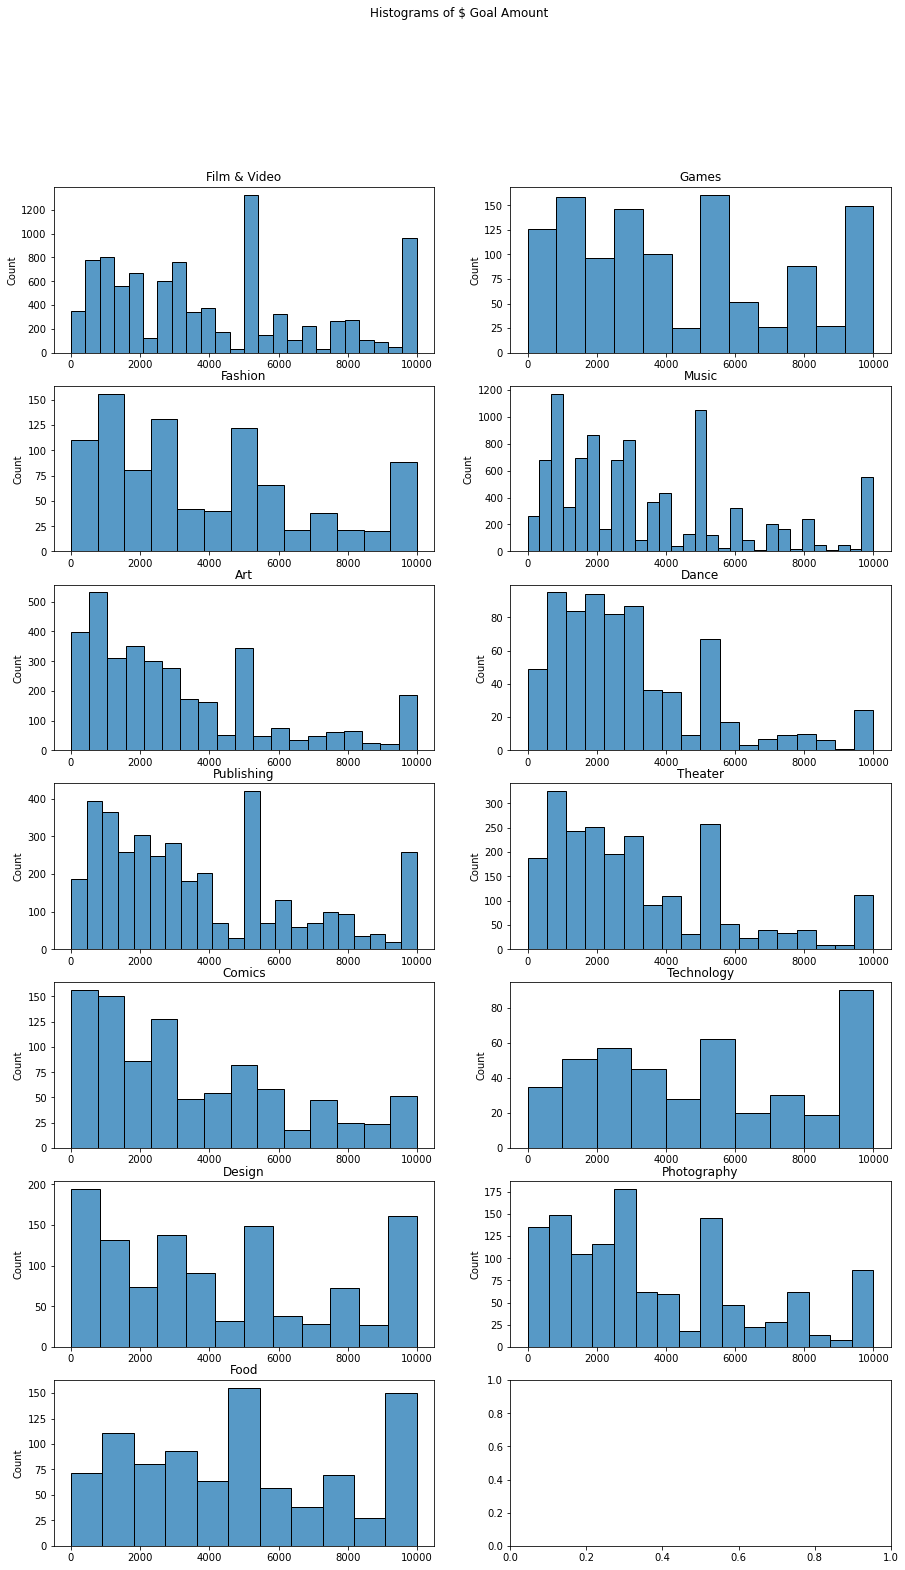

In [33]:
#Let's do histogram plots for every quant column
#Let's map out the histogram for all the categories and what they raised
num_catergories= final_data.category.nunique()
# print(num_catergories)
category_list = final_data.category.unique() #list of categories
fig, axs = plt.subplots(7,2,figsize= (15,25))
fig.suptitle('Histograms of $ Goal Amount')

row_counter = 0
col_counter = 0
#figure out why your key for Film& Video isn't working!
# print(final_data.loc[final_data['category']== 'Games',['goal']])


#This cell plots all the histograms of all the different categories. We can now repeate this process for any other metric we are interested in

for index in category_list:
    sns.histplot(final_data.loc[final_data['category']== index,['goal']], binrange= [0, 10000], ax= axs[row_counter,col_counter], legend=False)
    axs[row_counter,col_counter].set_title(index)
    col_counter += 1
    
    if col_counter == 2:
        col_counter = 0
        if row_counter <= 5:
            row_counter +=1
    




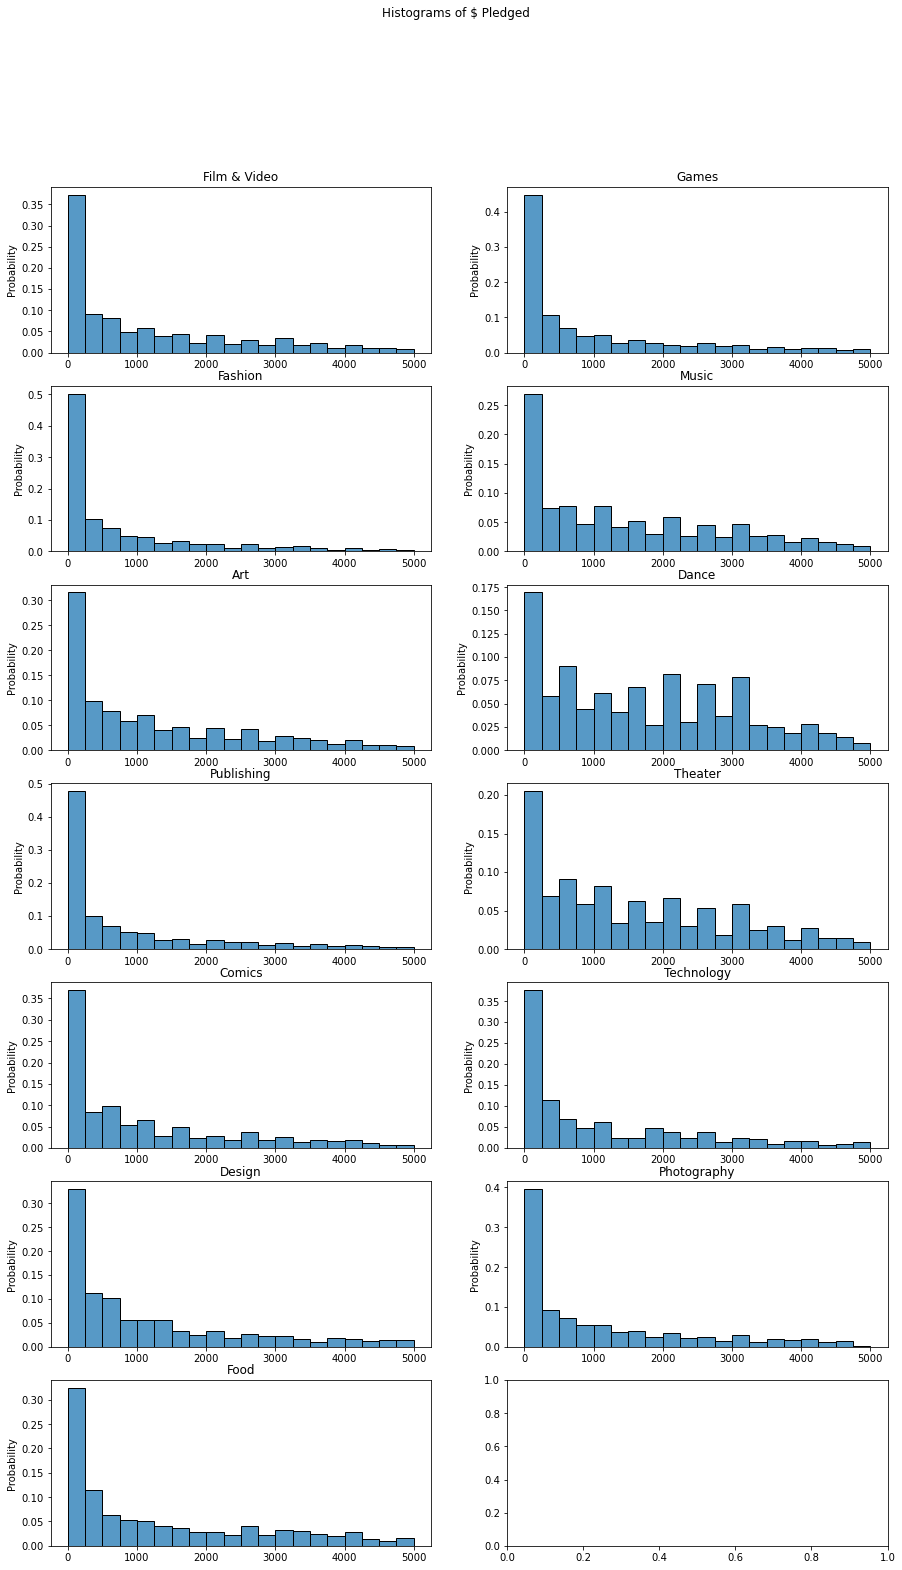

In [34]:
category_list = final_data.category.unique() #list of categories
#After looking at some initial plotting, I realized that sharing the y-axis would be a bad idea
fig, axs = plt.subplots(7,2,figsize= (15,25))
fig.suptitle('Histograms of $ Pledged')
row_counter = 0
col_counter = 0


for index in category_list:
    sns.histplot(final_data.loc[final_data['category']== index,['pledged']],bins= 20, ax= axs[row_counter,col_counter], binrange= [0, 5000],legend=False, stat='probability')
    axs[row_counter,col_counter].set_title(index)
    col_counter += 1
    
    if col_counter == 2:
        col_counter = 0
        if row_counter <= 5:
            row_counter +=1
            
# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

(0.0, 100000.0)

<Figure size 432x288 with 0 Axes>

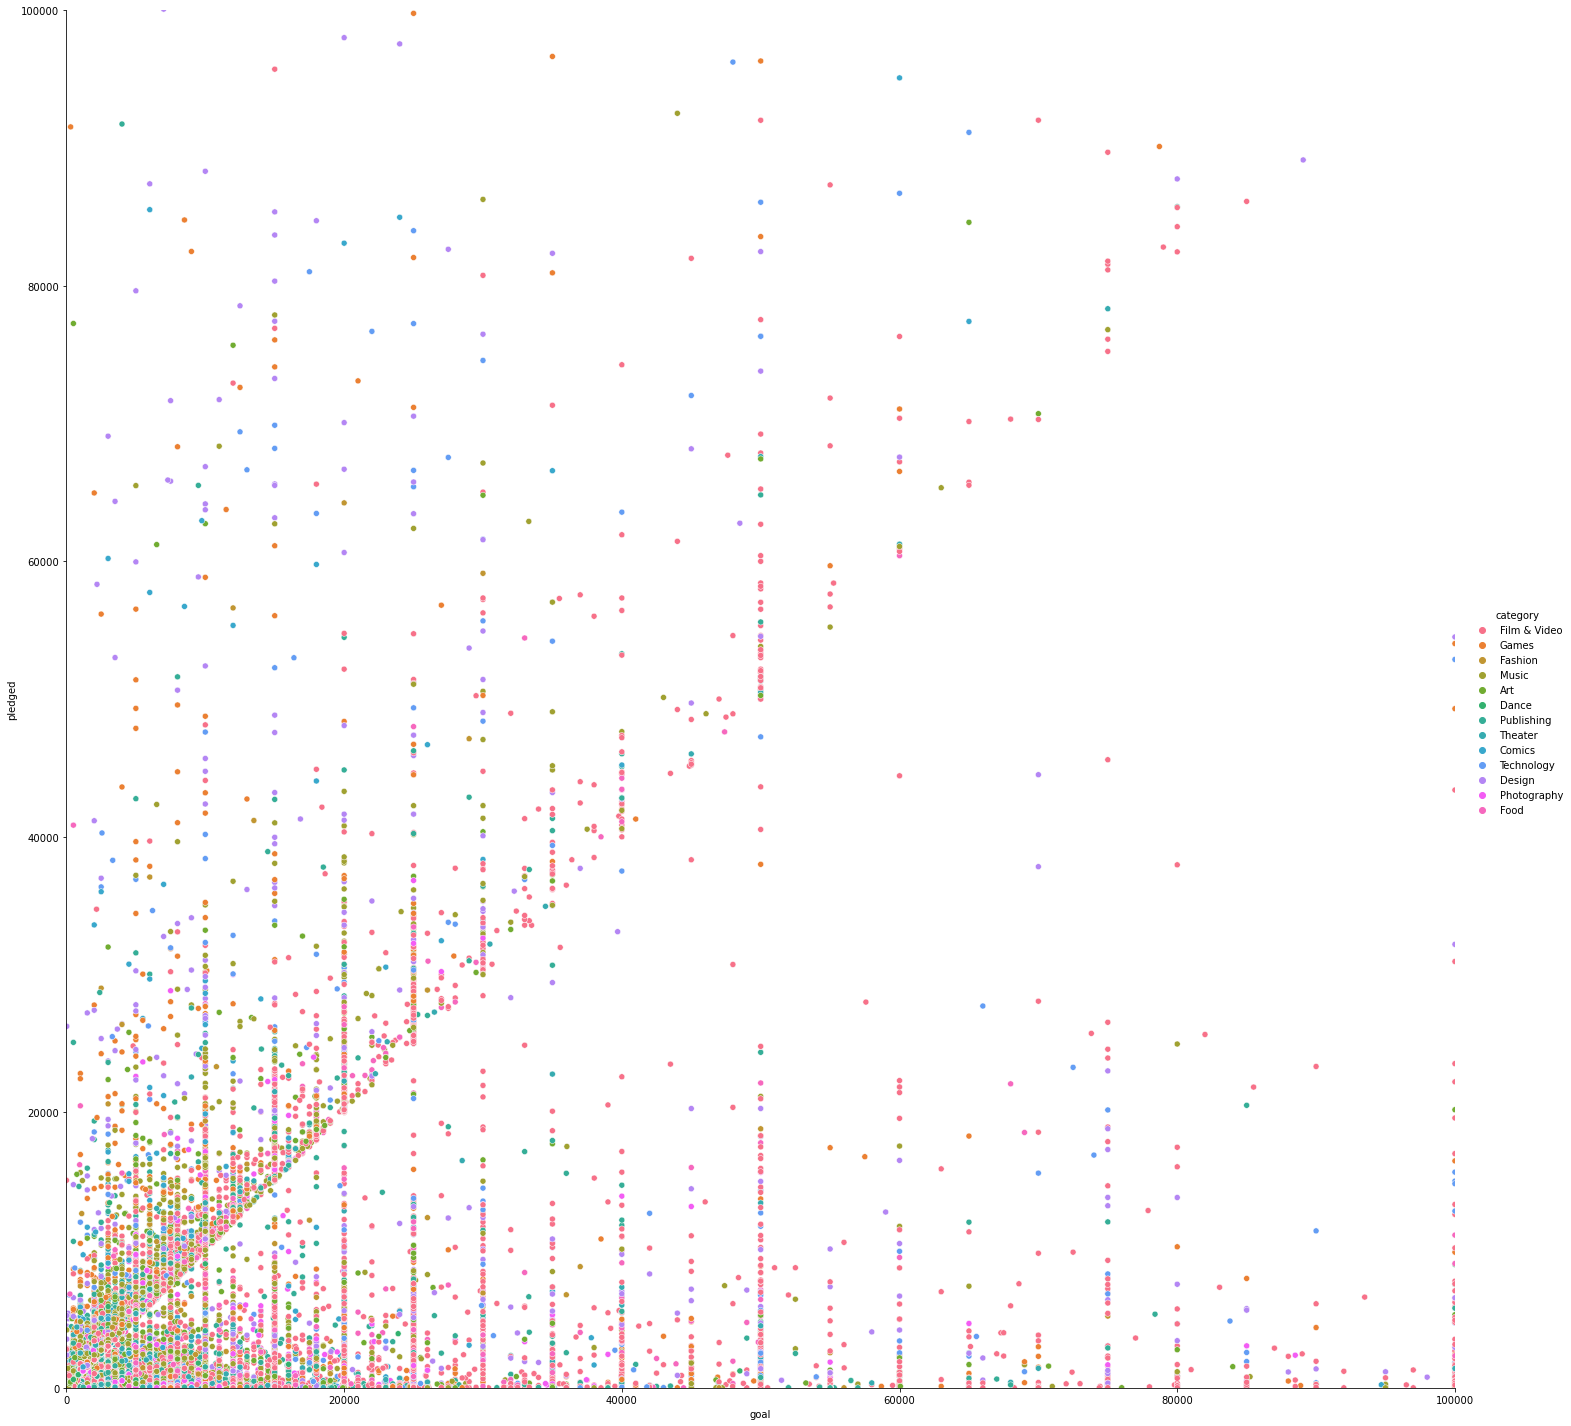

In [35]:
#Let's create overlapping histograms of amount pledged vs. amount raised. Maybe a scatter plot would be better?
# fig = plt.gcf()

# Change seaborn plot size
# fig.set_size_inches(20, 20)
# fig, axs = plt.subplots(1,5,figsize= (15,25))
plt.clf()
# ongoing_data = 
sns.relplot(x= 'goal', y='pledged', hue='category', data= final_data, height = 20)
# control x and y limits
plt.ylim(0, 100000)
plt.xlim(0, 100000)



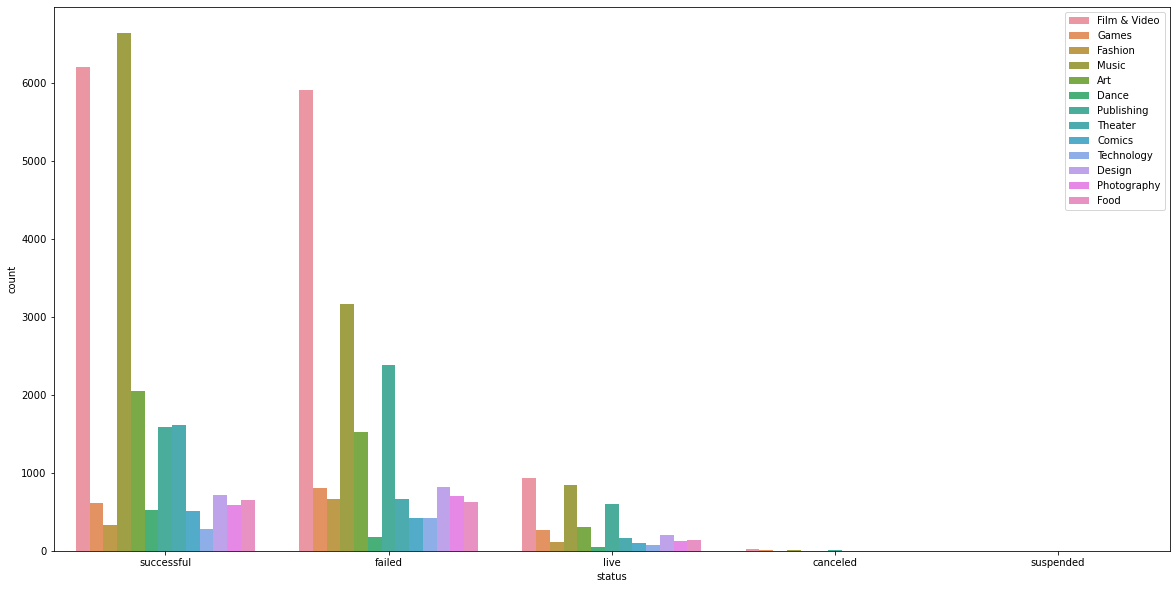

In [36]:
#Let's look at which category was the most sucessful

plt.figure(figsize=(20,10))
ax = sns.countplot(x="status", hue="category", data=final_data)
plt.legend(loc='upper right')

In [37]:
# sns.histplot(final_data['goal'])

In [38]:
print(final_data['goal'].describe())

count    4.459200e+04
mean     1.210894e+04
std      1.916062e+05
min      5.000000e-01
25%      1.800000e+03
50%      4.000000e+03
75%      1.000000e+04
max      2.147484e+07
Name: goal, dtype: float64


In [39]:
# quartile_range= (final_data['goal'].percentile(75) - final_data['goal'].percentile(75))
iq_range= np.percentile(final_data['goal'],75) - np.percentile(final_data['goal'],25)
outlier_limit = 1.5*iq_range +np.percentile(final_data['goal'],75)
print(outlier_limit)
# print(quartile_range)

22300.0


In [40]:
num_outliers = len(final_data.loc[final_data['goal'] > outlier_limit])
num_of_projects = len(final_data['goal'])

percent_outliers = (num_outliers/num_of_projects)* 100
print("Percent of Data being Outliers")
print(percent_outliers)


Percent of Data being Outliers
8.474614280588447


In [41]:
num_success_outliers = len(final_data.loc[(final_data['goal'] > outlier_limit) & (final_data['status'] == "successful")])
percent_success_outliers = (num_success_outliers/num_outliers)*100
print(percent_success_outliers)

18.920349298756285


In [42]:
# plt.clf()
# sns.histplot(final_data, x= 'goal', stat="count", binwidth = '1000')


<Figure size 432x288 with 0 Axes>

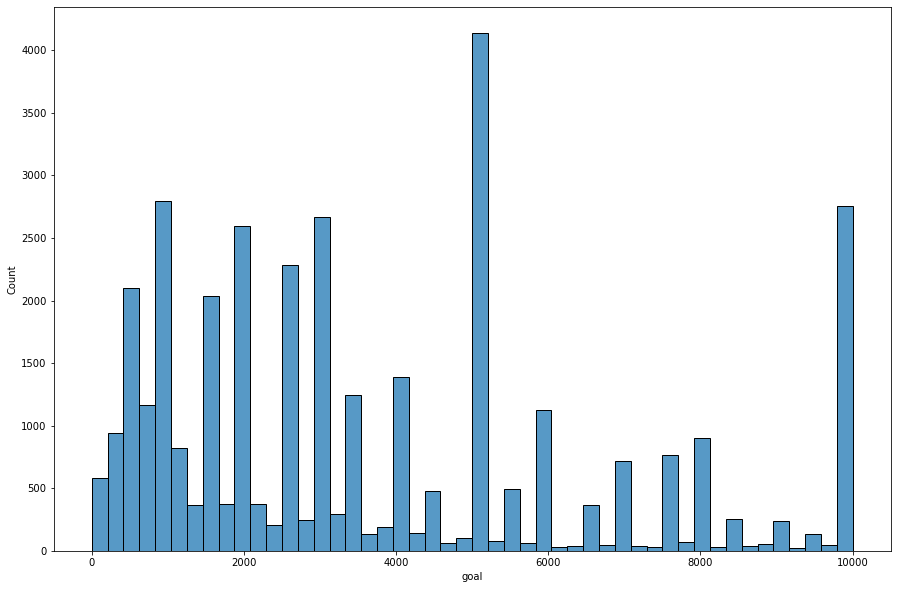

In [43]:
plt.clf()
plt.figure(figsize=(15,10))
ax= sns.histplot(final_data, x= 'goal', stat="count", binrange = [0,10000])


<Figure size 432x288 with 0 Axes>

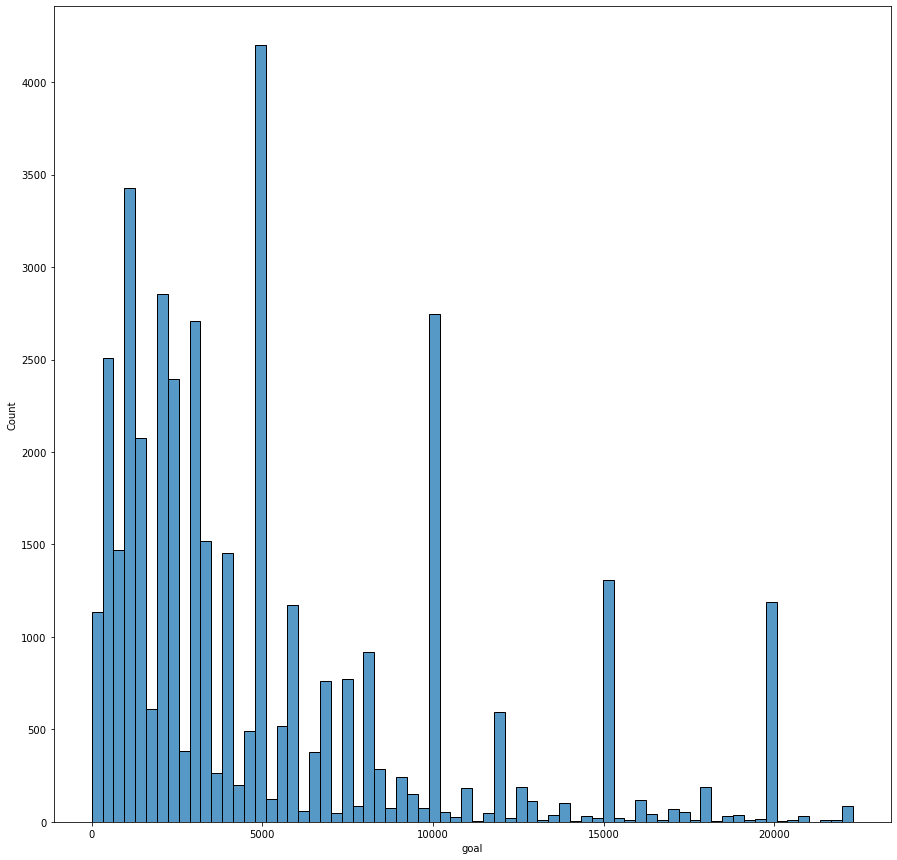

In [44]:
plt.clf()
plt.figure(figsize=(15,15))
ax= sns.histplot(final_data, x= 'goal', stat="count", binrange = [0,outlier_limit])


<Figure size 432x288 with 0 Axes>

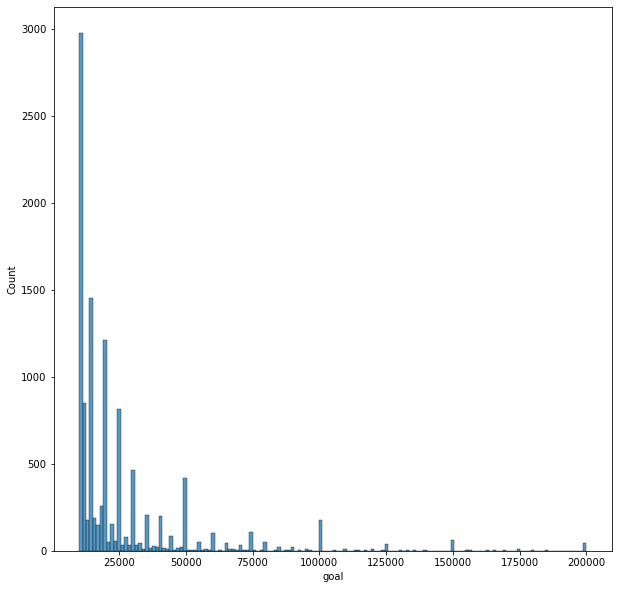

In [45]:
plt.clf()
plt.figure(figsize=(10,10))
ax= sns.histplot(final_data, x= 'goal', stat="count", binrange = [10000,200000])

<Figure size 432x288 with 0 Axes>

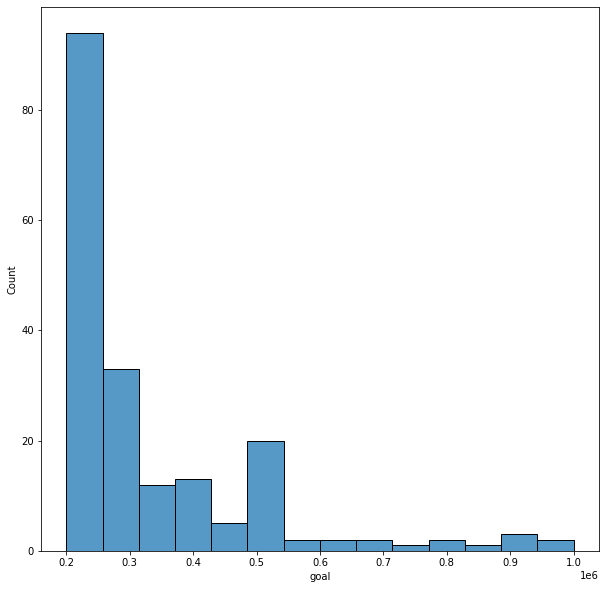

In [46]:
plt.clf()
plt.figure(figsize=(10,10))
ax= sns.histplot(final_data, x= 'goal', stat="count", binrange = [200000,1000000])

<Figure size 432x288 with 0 Axes>

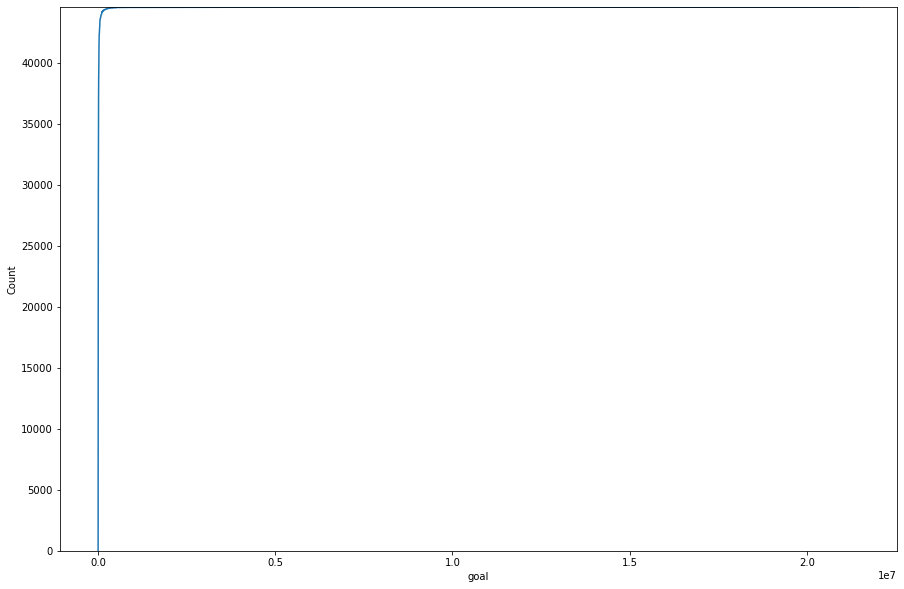

In [47]:
plt.clf()
plt.figure(figsize=(15,10))
ax= sns.ecdfplot(final_data, x= 'goal', stat="count")

In [48]:
#We will use this dataframe as the input for our logistic regression model
#no_outlier_regression_data = nord
nord = final_data.loc[final_data['goal'] < outlier_limit]
nord = nord[(nord['status']== 'successful')|(nord['status']=='failed')]
nord.head()


,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,Day of Week,Funded Date,Funded Time,reward_levels
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,109.952381,66,7,10,2,30.00,Fri,2011-08-19,19:28:17,"$25,$50,$100,$250,$500,$1,000,$2,500"
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.500000,2,5,6,0,47.18,Mon,2010-08-02,03:59:00,"$1,$5,$10,$25,$50"
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,108.916667,100,13,4,0,32.22,Sun,2012-04-08,02:14:00,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500..."
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,2011-06-01,15:25:39,"$10,$25,$50,$100,$150,$250"
5,316217,Dinner Party - a short film about friendship.....,http://www.kickstarter.com/projects/249354515/...,Film & Video,Short Film,"Portland, OR",successful,3500.0,3582.0,102.333143,39,7,8,0,21.43,Wed,2011-06-22,13:33:00,"$5,$25,$50,$100,$250,$500,$1,000"


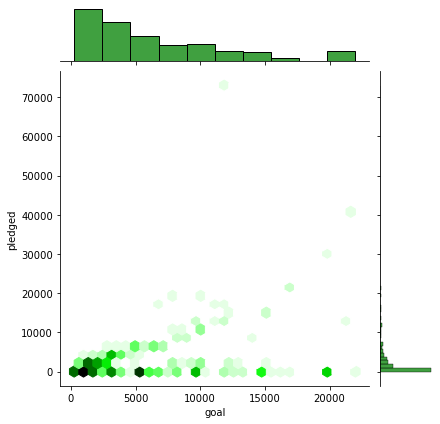

In [49]:
j = sns.jointplot(data=nord[nord.subcategory == 'Animation'], x='goal',y='pledged', color='Green', kind = "hex")


### Scatter Plot of Pledged vs. Goal Amount for all subcategories, seperated by failed and successful projects

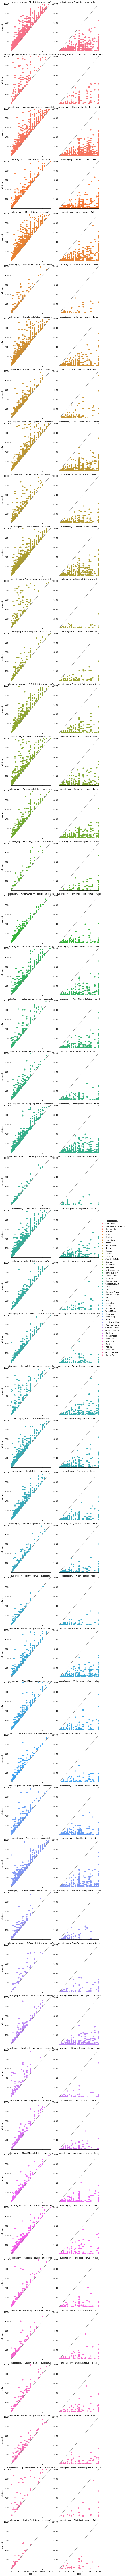

In [50]:


g2 = sns.FacetGrid(nord, row='subcategory', col='status' ,hue='subcategory', sharey= False, height= 4)
g2= g2.map(plt.scatter, 'goal' , 'pledged')
g2.set(xlim=(0,10000), ylim=(1,10000)) #ths sets the graph boundaries

for ax in g2.axes.flat:
    ax.plot((0,10000),(0,10000),c='gray', ls="--")
g2.add_legend()

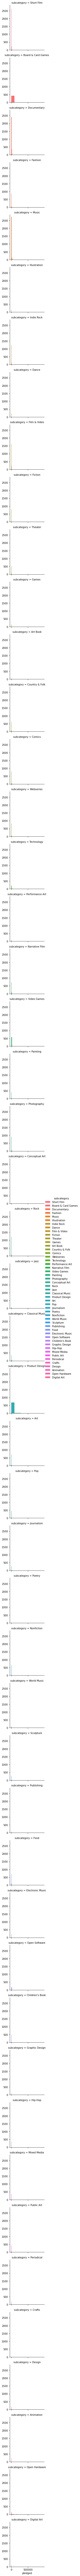

In [68]:
# plt.clf()
# plt.close()
# g3 = sns.FacetGrid(nord, row='subcategory',hue='subcategory',)
# g3= g3.map(plt.hist, 'pledged')
# g3.add_legend()

In [62]:
len(nord.category.unique())

13

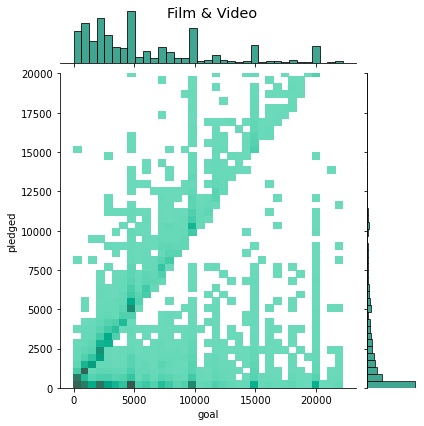

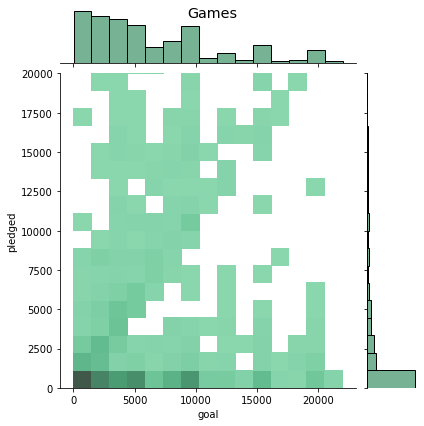

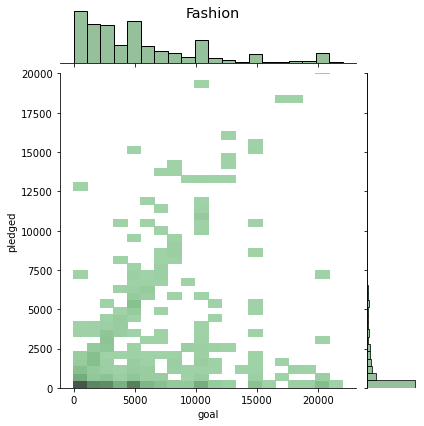

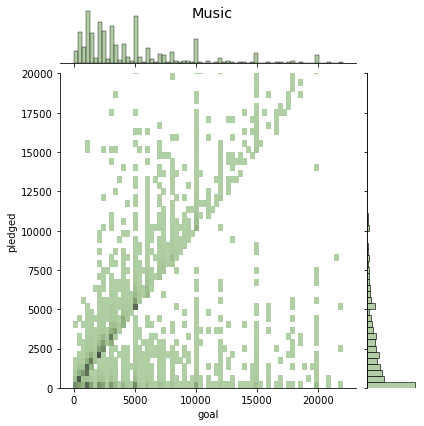

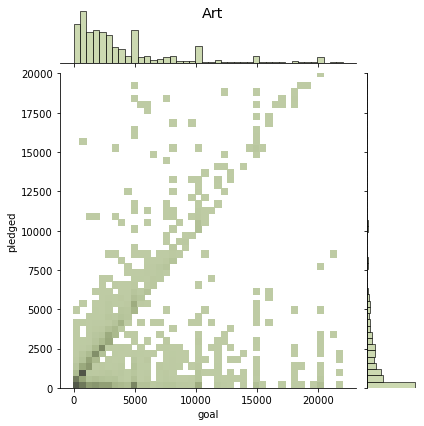

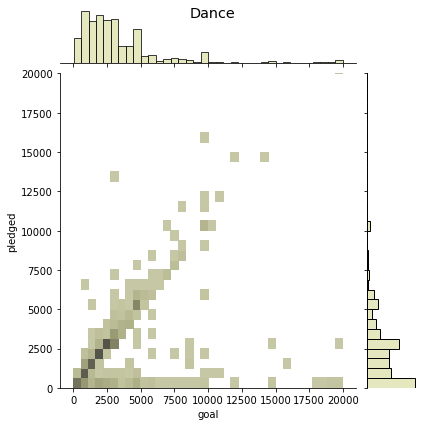

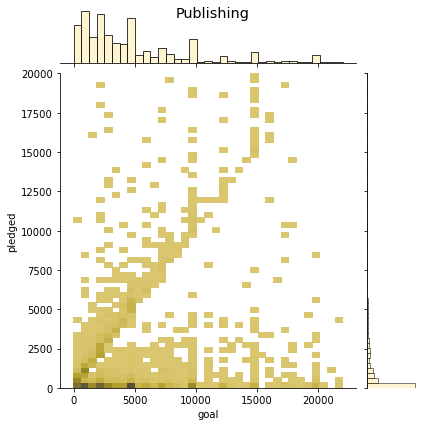

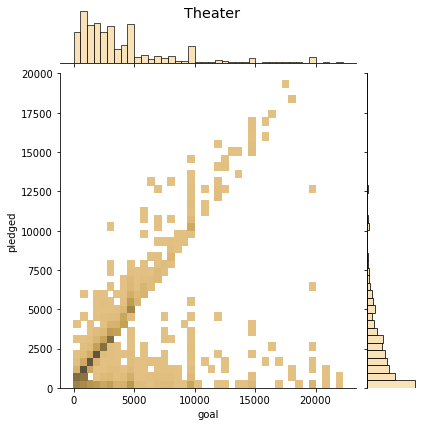

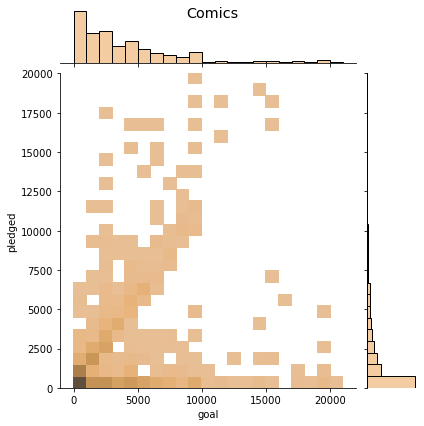

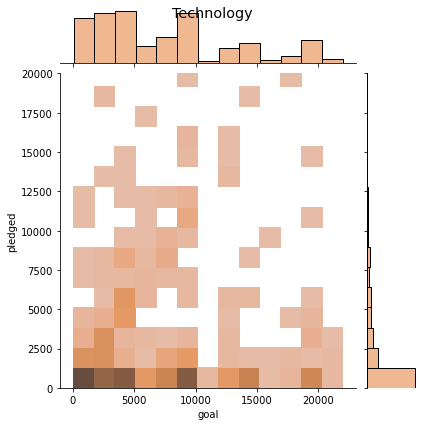

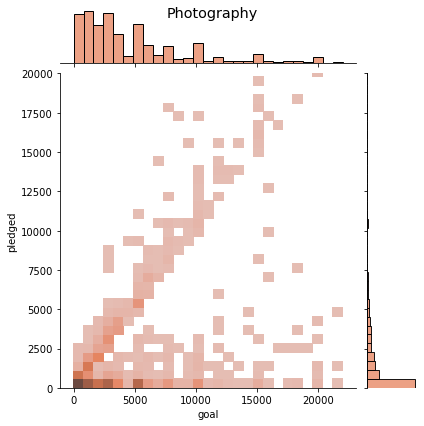

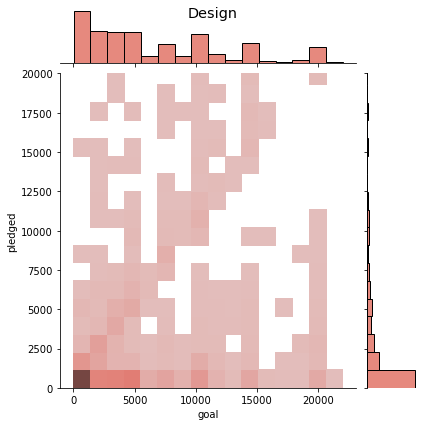

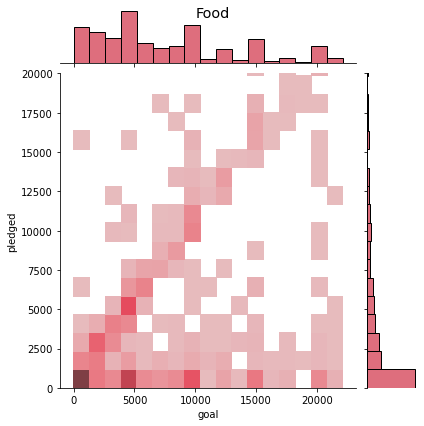

In [85]:
plt.cla()
plt.clf()
plt.close()

category_list = nord.category.unique() #list of categories


color_list= ['#00876c', '#4a9972','#73ab7b','#98bc87','#bbcd97','#dddfaa','#fef1c1','#f7d7a0','#f1bc83','#eca06c','#e6825c','#de6253','#d43d51']

i=0
for index in category_list:
    g4 = sns.jointplot(data=nord[nord['category'] == index],x='goal',y='pledged',color = color_list[i],kind='hist', ylim= {0, 20000})
    g4.fig.suptitle(index, fontsize= 'x-large')
    i += 1



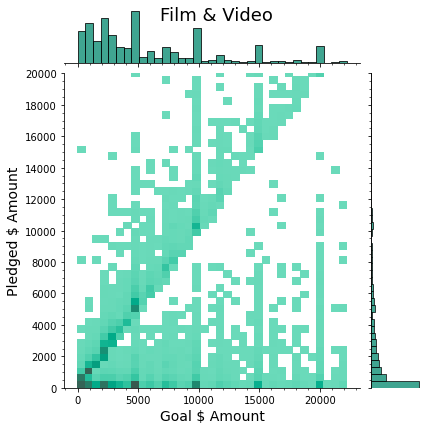

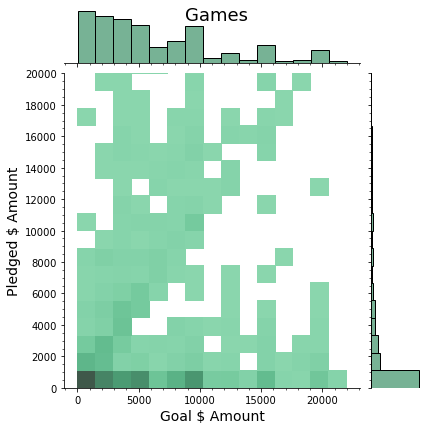

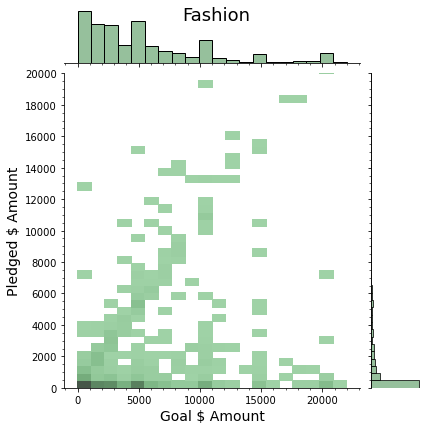

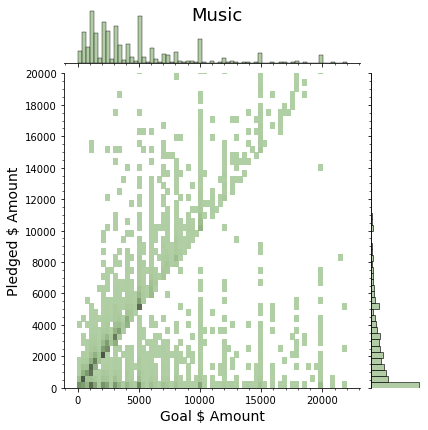

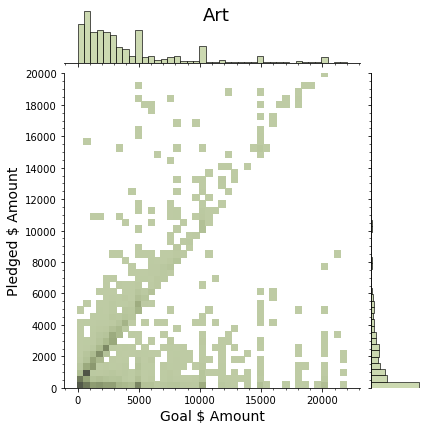

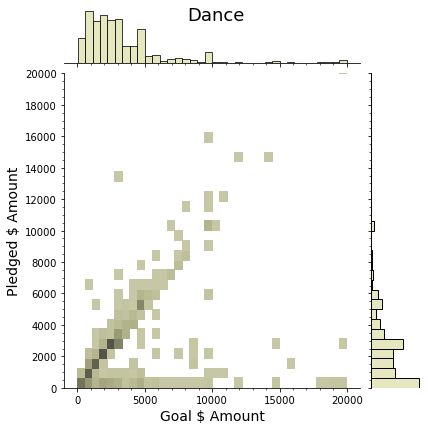

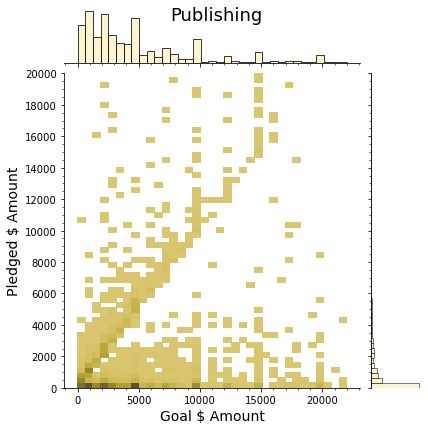

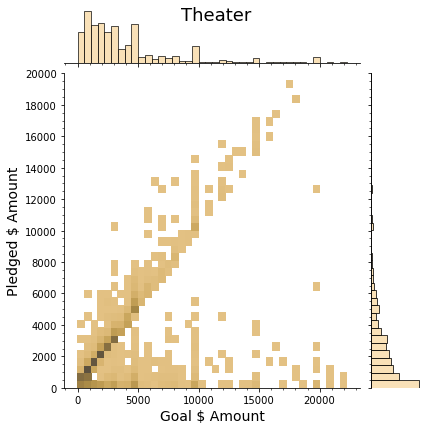

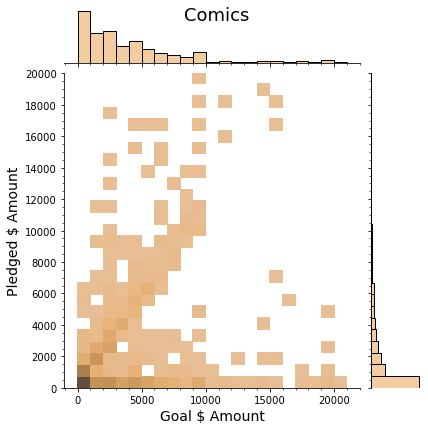

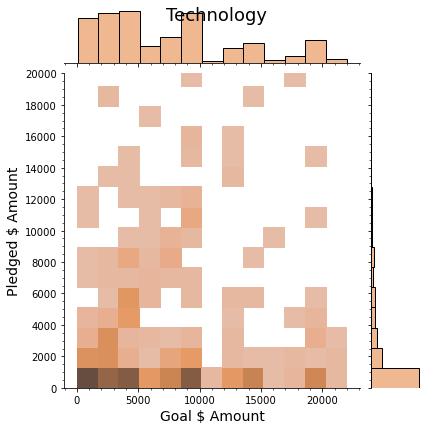

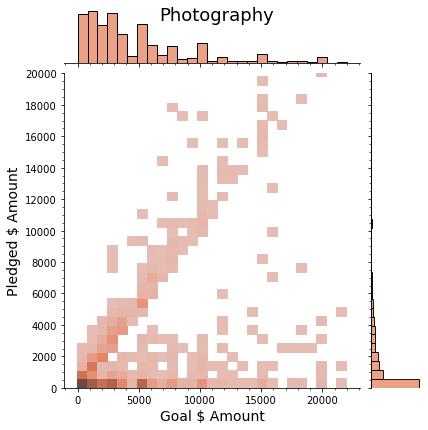

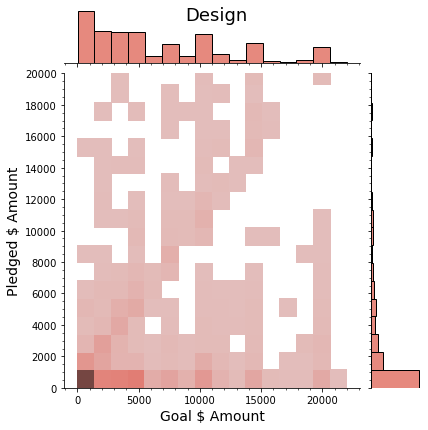

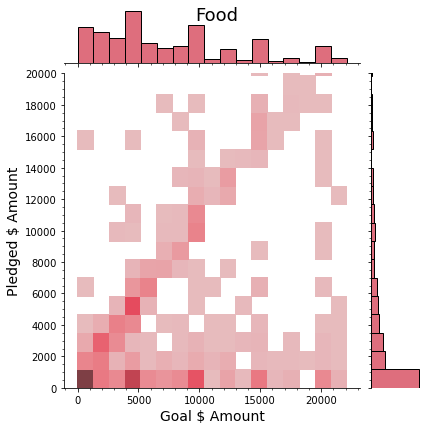

In [108]:
## I am going to attempt to create this plot from scratch
plt.cla()
plt.clf()
plt.close()

category_list = nord.category.unique() #list of categories


color_list= ['#00876c', '#4a9972','#73ab7b','#98bc87','#bbcd97','#dddfaa','#fef1c1','#f7d7a0','#f1bc83','#eca06c','#e6825c','#de6253','#d43d51']

i=0
for index in category_list:
    g4 = sns.JointGrid(data=nord[nord['category'] == index],x='goal',y='pledged',ylim= {0, 20000})
    g4.plot(sns.histplot,sns.histplot, color = color_list[i])
    g4.fig.suptitle(index, fontsize= 18)
    g4.ax_joint.set_xlabel('Goal $ Amount', fontsize = 14)
    g4.ax_joint.set_ylabel('Pledged $ Amount', fontsize = 14)
    # g4.ax_joint.minorticks_on()
    # g4.ax_joint.yaxis.set_minor_locator(plt.NullLocator())
    g4.ax_joint.xaxis.set_major_locator(plt.MultipleLocator(5000))
    g4.ax_joint.xaxis.set_minor_locator(plt.MultipleLocator(1000))
    g4.ax_joint.yaxis.set_major_locator(plt.MultipleLocator(2000))
    g4.ax_joint.yaxis.set_minor_locator(plt.MultipleLocator(500))
    i += 1



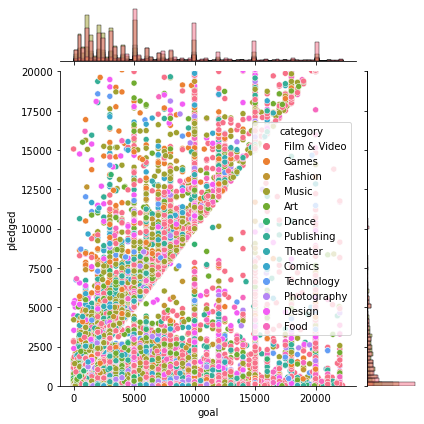

In [73]:
# g5 = sns.JointGrid(data=nord, x="goal", y="pledged", hue="category", ylim= {0, 20000})
# g5.plot(sns.scatterplot, sns.histplot)